In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import math

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode


In [2]:
class Labels():
    def __init__(self,path):
        self.dataframe = pd.read_csv(path)
        self.transform = LabelTransform(self)
        self.override_params = True
        self.infotype = "Angle"
        #categorical attributes
        self.maximum = 1.05
        self.minimum = -1.05
        self.num_categories = 21
        #directional attributes
        self.directions = {"left":[[-1.05,0]],"straight":[[-0.01,0.01]],"right":[[0,1.05]]}
        
    def set_type(self,type):
        if type == "angular":
            self.infotype = "Angle"
        if type == "categorical":
            self.infotype = "Category"
            if self.override_params and 'Category' not in self.dataframe.columns:
                self.transform.categorize(self.maximum,self.minimum,self.num_categories)
        if type == "directional":
            self.infotype = "Direction"
            if self.override_params and 'Direction' not in self.dataframe.columns:
                self.transform.directionalize(self.directions)
                
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        return self.dataframe.iloc[index][self.infotype]
    
    def histogram(self):
        return self.dataframe[self.infotype].hist()
        

In [3]:
class LabelTransform():
    def __init__(self,labels):
        self.labels = labels.dataframe
        
    def column_rule(self,column_name, function):
        self.labels[column_name] = self.labels.apply(lambda x: function(x.Angle), axis=1)
        
    def categorize(self, maximum, minimum, num_categories):
        def func(angle):
            if angle == maximum:
                return num_categories - 1
            scale = num_categories/(maximum-minimum)
            return math.floor(scale*(angle-minimum))
        
        #apply the categorization to the column
        self.column_rule("Category",func)
        
        #return the categories created
        num_range = np.linspace(minimum,maximum,num_categories+1)
        categories = [[round(num_range[i],3), round(num_range[i+1],3)] for i in range(len(num_range)-1)]
        
        return categories
    
    def directionalize(self,directions):
        def direction(angle):
            for key in directions:
                for interval in directions[key]:
                    start,end = interval
                    if start < angle and end > angle:
                        return key
        self.labels['Direction'] = self.labels.apply(lambda x: direction(x.Angle), axis=1)
        

In [4]:
class Images():
    def __init__(self,path):
        self.path = path
        self.transform = ImageTransform()
        self.stack_size = 1
        self.grayscale = False
        
    def get_stack(self,index,stack_size):
        img_filenames = ["{0}{1:06d}.jpg".format(self.path, i) 
                         for i in range(index, index+stack_size)]
        images = np.array([io.imread(img_filename).transpose((2,0,1)) for img_filename in img_filenames])
        images = self.transform.apply(images)
        #if not self.grayscale:
        image_stack = np.concatenate(images, axis=0)
        return images
    
    def show(self,stack):
        print(stack.shape)
        if self.grayscale:
            stack = stack.squeeze()
            f, ax = plt.subplots(stack_size, 1, figsize=(1*self.stack_size,25))
            ax.imshow(stack,cmap='gray')
            
        else:
            f, ax = plt.subplots(stack_size, 3, figsize=(3*self.stack_size,25))
            ax = ax.reshape((self.stack_size,3))
            for k in range(3*self.stack_size):
                i,j = k//3, k % 3
                ax[i,j].imshow(stack[k],cmap='gray')
                
        
            
    def set_grayscale(self, switch):
        if self.grayscale != switch:
            self.grayscale = switch
            if switch:
                self.transform.add("grayscale")
            else:
                self.transform.remove("grayscale")
        

In [5]:
class ImageTransform():
    def __init__(self):
        self.transformations = []
        
    def apply(self,images):
        for transformation in self.transformations:
            function = getattr(self,transformation)
            images = function(images)
        return images
    
    def add(self,name):
        self.transformations.append(name)
        
    def remove(self,name):
        if name in self.transformations:
            self.transformations.remove(name)
    
    def grayscale(self,images):
        if images.shape[1] != 3:
            return images
        r, g, b = images[:,0,:,:], images[:,1,:,:], images[:,2,:,:]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray

In [6]:
class ControlsDataset(Dataset):
    """Dataset that maps camera images into steering angle"""
    def __init__(self, stack_size = 1 ,img_folder = 'data/', csv_path='data/data.csv'):
        self.stack_size = stack_size
        self.images = Images(img_folder)
        self.labels = Labels(csv_path)
    
    def split(self,train=0.8,test=0.2):
        
        indices = list(range(len(self)))
        split = int(np.floor(test * len(self)))

        # spliting the dataset
        train_indices, val_indices = indices[split:], indices[:split]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        # Training data loader # NOTE had to remove shuffle
        self.dataloader = DataLoader(self, batch_size = 256, num_workers = 0, sampler=train_sampler)

        # Validation data loader # NOTE had to remove shuffle
        self.validloader = DataLoader(self, batch_size = 256, num_workers = 0, sampler=valid_sampler)

        print("Total training stacks", len(self.dataloader))
        print("Total validation stacks",len(self.validloader))
    
    def __len__(self):
        return len(self.labels) - self.stack_size
    
    def __getitem__(self, idx):
        #get a stack of images
        image_stack = self.images.get_stack(idx,self.stack_size)
        # use the latest image as the control
        label = self.labels[idx+self.stack_size]
        label = np.array([label])
        #combine stack and label together
        sample = {'image': image_stack, 
                  'control': label}
        return sample

(1, 480, 640)
(1, 480, 640)


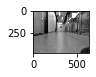

In [7]:
if __name__ == "__main__":
    stack_size = 1
    dataset = ControlsDataset(stack_size)
    dataset.labels.set_type("categorical")
    #dataset.images.transform.add("grayscale")
    #dataset.images.set_grayscale(True)
    dataloader = DataLoader(dataset, batch_size = 4, shuffle = True, num_workers = 0)
    
    img_stack = dataset[0]['image']
    print(img_stack.shape)
    
    dataset.images.show(img_stack)
    #f, ax = plt.subplots(stack_size, 1, figsize=(1*stack_size,25))
    #img_stack = img_stack.squeeze()
    #ax.imshow(img_stack,cmap='gray')
    
    